In [26]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import random
import numpy as np
import pylab
import quandl
quandl.ApiConfig.api_key = "32peB6ExRM7Lihbpsdsd"
import seaborn as sns
sns.set()
%matplotlib inline
#textblob to apply sentiment analysis 
from textblob import TextBlob
# import preprocessor as p

#For LSTM
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# Getting Stocks

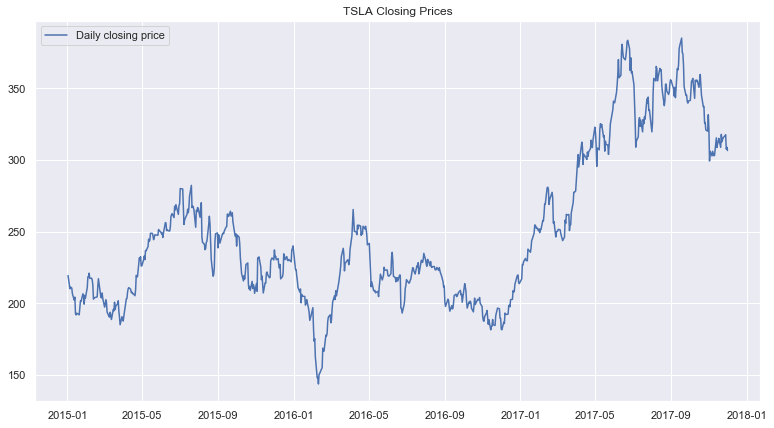

In [2]:
from pandas.plotting import register_matplotlib_converters
start = datetime.datetime(2015,1,1) # Beginning of period 
end = datetime.datetime(2017,12,1) # End of period 
stock = "TSLA" # some stock label we are interested in
data = quandl.get("WIKI/" + stock, start_date=start, end_date=end)
pylab.rcParams['figure.figsize'] = (13, 7)
plt.title(stock + " Closing Prices")
plt.plot(data["Close"],label="Daily closing price") # plot daily closing prices 
plt.legend()
plt.show()

In [3]:
data['Date'] = data.index
new_data = pd.DataFrame(index=range(0,len(data)),columns=['Date', 'Close'])
for i in range(0,len(data)):
     new_data['Date'][i] = data['Date'][i]
     new_data['Close'][i] = data['Close'][i]

      
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)    

In [4]:
new_data.tail()

,Close
Date,
2017-11-27,316.81
2017-11-28,317.55
2017-11-29,307.54
2017-11-30,308.85
2017-12-01,306.53


# Predicting stock developtment using LSTM (Long Short Term Memory)

## Multivariate LSTM

In [180]:
# print(new_data.head())
ts = pd.read_csv('../data/tweets_and_stock_on_stockOpenDays.csv', index_col = 0)
print(ts.shape)
ts.set_value('2015-01-01','Close', ts.iloc[1]['Close'])
ts.head(2)


(253, 4)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


,polarity,subjectivity,pseudo_tweets_count,Close
2015-01-01,0.127195,0.279125,50,219.31
2015-01-02,0.112455,0.302081,114,219.31


### Preapre mulrivariate training data

We decide to use only 'polarity' and 'close price' for the features of LSTM.
Including all four tweets features actually makes the model performance worse

Two Variable

In [181]:
# ts_train.head()
ts = ts[['Close', 'polarity']]

In [182]:
#
ts_dataset = ts.values
ts_train = ts_dataset[:200]
ts_validation = ts_dataset[200:]

#scale the data
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_ts_train = X_scaler.fit_transform(ts_train)
scaled_ts_validation = X_scaler.fit_transform(ts_validation)
y_scaler.fit_transform(ts['Close'].values[:200].reshape(-1,1))
# print(scaled_ts_train.shape)
# print(scaled_ts_train[0])


memory = 60;
j=0;

ts_X_train, ts_y_train = [], []
for i in range(memory,len(ts_train)):
    ts_X_train.append(scaled_ts_train[i - memory:i])   #***it's here 
    ts_y_train.append(scaled_ts_train[i,0])
    
#     if j<=3:
#         print(j)
#         print(scaled_ts_train[i - memory:i,0])
# #         print('ts_X_train: ',ts_X_train)
#     j+=1
    
ts_X_train, ts_y_train = np.array(ts_X_train), np.array(ts_y_train)
print(ts_X_train.shape)
# x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],))
# print(ts_X_train.shape)
# print(ts_X_train[0].shape)
# print(ts_X_train[1])

(140, 60, 2)


In [183]:
tweets_model = Sequential()
tweets_model.add(LSTM(units=50, return_sequences=True, input_shape=(ts_X_train.shape[1],ts_X_train.shape[2])))
#input shape  = (len(memory), number of features)
tweets_model.add(LSTM(units=50))
tweets_model.add(Dense(1))

tweets_model.compile(loss='mean_squared_error', optimizer='adam')
tweets_model.fit(ts_X_train, ts_y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 22s - loss: 0.0283


In [184]:
#gather X_test which has 60-day memory
#predicting values, using past 60 from the train data
inputs = ts[len(ts_train) - memory:].values

# inputs = inputs.reshape(-1,)
#inputs is the last N ts data, which include all testing set and some training set
inputs  = X_scaler.transform(inputs)

X_test = []
for i in range(memory, inputs.shape[0]):
    X_test.append(inputs[i-memory:i])
X_test = np.array(X_test)

# X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = tweets_model.predict(X_test)
closing_price = y_scaler.inverse_transform(closing_price)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


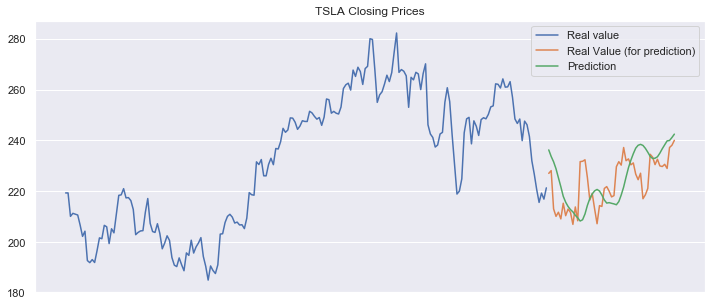

In [185]:
# train = new_data[:500]
# valid = new_data[500:]
# valid['Predictions'] = closing_price
# plt.plot(train['Close'], label = "Real value");
# plt.plot(valid['Close'],label='Real Value (for prediction)');
# plt.plot(valid['Predictions'],label="Prediction");
# plt.title(stock + " Closing Prices")
# plt.legend()
plt.figure(figsize=(12,5))
ts_train = ts[:200]
ts_validation = ts[200:]
ts_validation['Predictions'] = closing_price
plt.plot(ts_train['Close'], label = "Real value");
plt.plot(ts_validation['Close'],label='Real Value (for prediction)');
plt.plot(ts_validation['Predictions'],label="Prediction");
plt.title(stock + " Closing Prices")
plt.xticks([]);
plt.legend()


In [154]:
X_test.shape

(53, 30, 2)

In [96]:
print(ts_X_train.shape[1],ts_X_train.shape[2])

30 4


## One variable

In [186]:
# print(new_data.head())
ts = pd.read_csv('../data/tweets_and_stock_on_stockOpenDays.csv', index_col = 0)
print(ts.shape)
ts.set_value('2015-01-01','Close', ts.iloc[1]['Close'])
ts.head(2)

(253, 4)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


,polarity,subjectivity,pseudo_tweets_count,Close
2015-01-01,0.127195,0.279125,50,219.31
2015-01-02,0.112455,0.302081,114,219.31


In [187]:
ts = ts[['Close']]

In [188]:



# ts_train.head()
ts = ts[['Close']]
#
ts_dataset = ts.values
ts_train = ts_dataset[:200]
ts_validation = ts_dataset[200:]

#scale the data
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_ts_train = X_scaler.fit_transform(ts_train.reshape(-1,1))
scaled_ts_validation = X_scaler.fit_transform(ts_validation.reshape(-1,1))
y_scaler.fit_transform(ts_validation.reshape(-1,1))
# print(scaled_ts_train.shape)
# print(scaled_ts_train[0])


memory = 30;
j=0;

ts_X_train, ts_y_train = [], []
for i in range(memory,len(ts_train)):
    ts_X_train.append(scaled_ts_train[i - memory:i])   #***it's here 
    ts_y_train.append(scaled_ts_train[i,0])
    
#     if j<=3:
#         print(j)
#         print(scaled_ts_train[i - memory:i,0])
# #         print('ts_X_train: ',ts_X_train)
#     j+=1
    
ts_X_train, ts_y_train = np.array(ts_X_train), np.array(ts_y_train)
print(ts_X_train.shape)
# x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],))
# print(ts_X_train.shape)
# print(ts_X_train[0].shape)
# print(ts_X_train[1])
tweets_model = Sequential()
tweets_model.add(LSTM(units=50, return_sequences=True, input_shape=(ts_X_train.shape[1],ts_X_train.shape[2])))
#input shape  = (len(memory), number of features)
tweets_model.add(LSTM(units=50))
tweets_model.add(Dense(1))

tweets_model.compile(loss='mean_squared_error', optimizer='adam')
tweets_model.fit(ts_X_train, ts_y_train, epochs=1, batch_size=1, verbose=2)


(170, 30, 1)
Epoch 1/1
 - 14s - loss: 0.0244


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


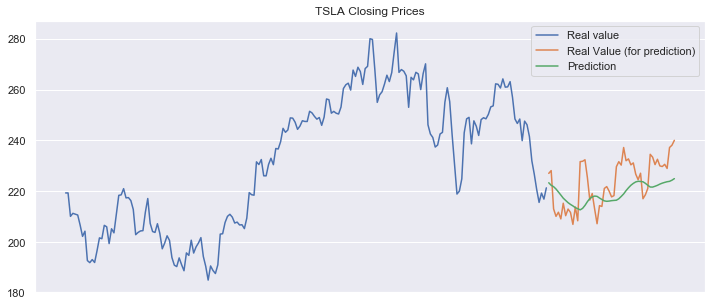

In [189]:
#gather X_test which has 60-day memory
#predicting values, using past 60 from the train data
inputs = ts[len(ts_train) - memory:].values
inputs = inputs.reshape(-1,1)

# inputs = inputs.reshape(-1,)
#inputs is the last N ts data, which include all testing set and some training set
inputs  = X_scaler.transform(inputs)

X_test = []
for i in range(memory, inputs.shape[0]):
    X_test.append(inputs[i-memory:i])
X_test = np.array(X_test)

# X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = tweets_model.predict(X_test)
closing_price = y_scaler.inverse_transform(closing_price)

plt.figure(figsize=(12,5))
ts_train = ts[:200]
ts_validation = ts[200:]
ts_validation['Predictions'] = closing_price
plt.plot(ts_train['Close'], label = "Real value");
plt.plot(ts_validation['Close'],label='Real Value (for prediction)');
plt.plot(ts_validation['Predictions'],label="Prediction");
plt.title(stock + " Closing Prices")
plt.xticks([]);
plt.legend()


In [122]:


#splitting into train and validation
#creating train and test sets
dataset = new_data.values

train = dataset[0:500]#using the first 500 days as a train set
valid = dataset[500:]


In [123]:
# print(train)

In [124]:
dataset.shape

(735, 1)

In [125]:
#converting dataset into x_train and y_train
#MinMaxScaler scale the data to range(0,1) with min, max value in the original
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(train)

memory = 60;
x_train, y_train = [], []
for i in range(memory,len(train)):
    x_train.append(scaled_data[i - memory:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
print(x_train.shape)

(440, 60, 1)


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


the training data is of the shape ( len(ts)-len(memory), len(memory), 1)

In [126]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)


Epoch 1/1
 - 52s - loss: 0.0161


In [127]:
new_data.head(3)
new_data.shape

(735, 1)

In [128]:
#gather X_test which has 60-day memory
#predicting values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

## Results

In [10]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

16.52182856975798

In [11]:
X_test.shape

(235, 60, 1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


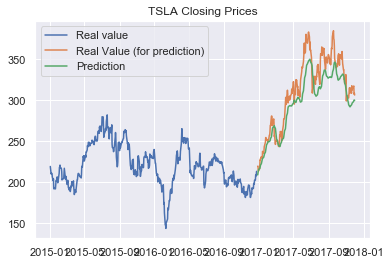

In [129]:
train = new_data[:500]
valid = new_data[500:]
valid['Predictions'] = closing_price
plt.plot(train['Close'], label = "Real value");
plt.plot(valid['Close'],label='Real Value (for prediction)');
plt.plot(valid['Predictions'],label="Prediction");
plt.title(stock + " Closing Prices")
plt.legend()

In [13]:
error_difference = pd.DataFrame(index=range(0,len(valid['Predictions'])),columns=['Close','Predictions','Error'])
for i in range(0,len(valid['Predictions'])):
     error_difference['Close'][i] = valid['Close'][i]
     error_difference['Predictions'][i] = valid['Predictions'][i]
     error_difference['Error'][i] = 100*abs(valid['Close'][i]-valid['Predictions'][i])/valid['Close'][i]


In [14]:
error_list = []
for index in range(0,len(error_difference)):
    error_list.append(error_difference['Error'][index])

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


3.905482441964633 3.3812044395978087


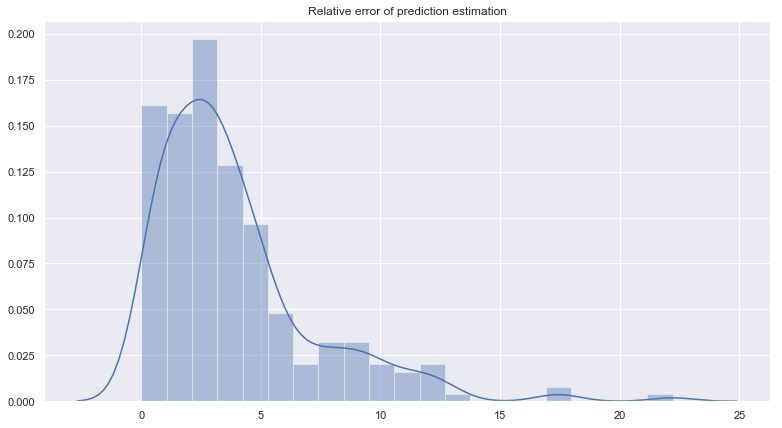

In [15]:
error_list=np.array(error_list)
sns.distplot(error_list, kde=True).set_title('Relative error of prediction estimation')
mean = error_list.mean()

rms=np.sqrt(np.mean(np.power((error_list-mean),2)))
print(mean,rms)